In [1]:
import os, glob
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import pickle
import json
import csv
#import yaml

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense
from tensorflow.keras import callbacks
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.activations import relu
from tensorflow.keras.optimizers import SGD
import tensorflow_addons as tfa
from qhoptim.tf import QHAdamOptimizer

from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
!pwd

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder


# Summarize trial.json

In [3]:
proj_name = 'specific'
fn_save = 'RESULTS_{}.pkl'.format(proj_name)
dir_results = '../training/tuning_directory/' + proj_name + "/"
dir_trials = os.path.join(dir_results, 'trial_*')
print("fn_save:")
print(fn_save)
print("dir_trials:")
print(dir_trials)
# to pandas:
fn_save_pkl = fn_save.split('.')[0] + '.pandas.pkl'
print("fn_save_pkl:")
print(fn_save_pkl)

fn_save:
RESULTS_specific.pkl
dir_trials:
../training/tuning_directory/specific/trial_*
fn_save_pkl:
RESULTS_specific.pandas.pkl


In [4]:
if not os.path.exists(fn_save):

    RESULTS = {}
    for ktrial in glob.glob(dir_trials):
        trial_id = ktrial.split('/')[-1]    
        
        ### json
        f_json  = ktrial + '/trial.json'
        with open(f_json) as f:
            work = json.load(f)
#         if work['status'] == 'RUNNING':
#             print('Skip %s (incomplete trial)'%trial_id)
#             continue
        
        # num layer
        # make sure your hp name is set correctly, e.g., 'num_layers'
#         num_layers = work['hyperparameters']['values']['num_layers']
        
        # units
        # make sure your hp name is set correctly, e.g., 'units_%d'
        # make sure the index k for units_%d is correct, e.g., k starts from 0 or 1
#         if 'units_%d'%(num_layers+1) not in work['hyperparameters']['values'].keys(): # +1 is for jerry's tuner
#             print('Skip %s (num_layers and #units mismatch)'%trial_id)
#             continue
#         else:
#             units = np.array([work['hyperparameters']['values']['units_%d'%k] for k in range(1,num_layers+2)])
        
        RESULTS[trial_id] = {}
#         RESULTS[trial_id]['num_layers'] = num_layers
#         RESULTS[trial_id]['units'] = units
        
        # other hyperparameters
        # again make sure to the hp names are correct, e.g., 'num_layers', 'units_%d'
        hp_list = work['hyperparameters']['values']
#         hp_list = [k for k, v in hp_list.items() if not k.startswith("unit")] # remove units_%d
#         hp_list = [k for k in hp_list if not k == 'num_layers']
        for khp in hp_list:
            RESULTS[trial_id][khp] = work['hyperparameters']['values'][khp]

        # minimum val_loss
        #print(ktrial)
        #print(work['metrics']['metrics']['val_loss']['observations'])
        RESULTS[trial_id]['min_val_loss'] = work['metrics']['metrics']['val_loss']['observations'][0]['value'][0]
        
        ### csv
        # only if a csv file for epoch-wise metrics were generated.
        if False:
            f_csv = ktrial + '/trial_epoch_metrics_execution-01.csv'

            if os.path.getsize(f_csv)==0: 
                print('Error (no csv): %s'%trial_id)
                del RESULTS[trial_id] 
                continue

            work2 = pd.read_csv(f_csv)['val_loss']
            work2 = work2.rename(trial_id)
            RESULTS[trial_id]['val_loss'] = work2 
            RESULTS[trial_id]['epochs'] = len(work2)

    # Add '# of trainable parameters'
    # make sure the #s of input, output variables
    units_input = 64
    units_output = 60
#     for ktrial in RESULTS.keys():
#         layers = np.array([units_input, *RESULTS[ktrial]['units'], units_output])
#         RESULTS[ktrial]['num_parameters'] = np.sum((layers[:-1]+1) * layers[1:])

    with open(fn_save,"wb") as f:
        pickle.dump(RESULTS, f)
        
else:
    with open(fn_save, 'rb') as f:
        RESULTS = pickle.load(f)
        


RESULTS_PD = pd.DataFrame.from_dict(RESULTS, orient='index')
RESULTS_PD.rename_axis('trial_id', inplace=True)
RESULTS_PD.sort_values('min_val_loss', ascending=True, inplace=True)
RESULTS_PD.reset_index(inplace=True)
RESULTS_PD.index = pd.RangeIndex(RESULTS_PD.index.start+1, RESULTS_PD.index.stop+1)
RESULTS_PD.rename_axis('rank', inplace=True)
RESULTS_PD.to_pickle(fn_save_pkl)

# Reading in pickle files

In [5]:
pd_proj = pd.read_pickle("RESULTS_" + proj_name + ".pandas.pkl")
summary = {proj_name:pd_proj}

In [6]:
pd_proj

,trial_id,leak,dropout,lr,hidden_units,num_layers,optimizer,L2_regularization,batch_normalization,min_val_loss
rank,,,,,,,,,,
1,trial_191,0.244854,0.035674,0.000017,301,7,adam,False,True,0.001553
2,trial_244,0.169453,0.007095,0.000016,205,5,RMSprop,False,True,0.001570
3,trial_093,0.033459,0.007286,0.000077,190,4,adam,False,False,0.001570
4,trial_145,0.163423,0.013074,0.001080,209,5,adam,False,True,0.001579
5,trial_086,0.013417,0.005763,0.000389,141,5,adam,False,False,0.001580
...,...,...,...,...,...,...,...,...,...,...
326,trial_305,0.342675,0.144501,0.000010,170,5,SGD,True,False,3.353847
327,trial_199,0.210074,0.133137,0.000152,379,10,SGD,True,False,4.147741
328,trial_090,0.168671,0.147901,0.000026,218,7,SGD,True,True,6.022971


In [7]:
pd_proj['min_val_loss']

rank
1       0.001553
2       0.001570
3       0.001570
4       0.001579
5       0.001580
         ...    
326     3.353847
327     4.147741
328     6.022971
329     8.339062
330    20.216667
Name: min_val_loss, Length: 330, dtype: float64

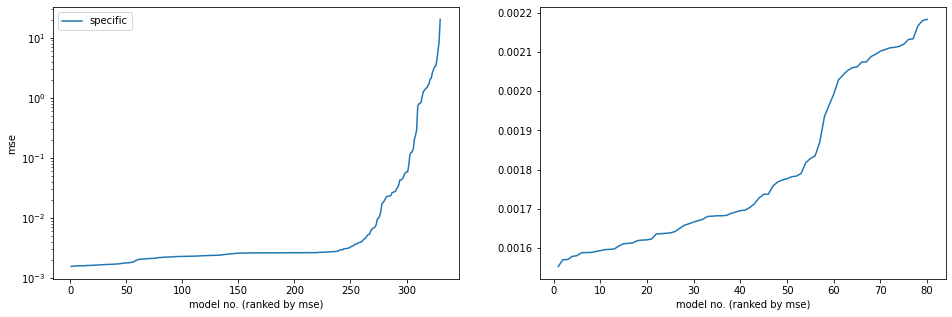

In [8]:
fig, ax_ =  plt.subplots(ncols=2)
ax = ax_[0]
pd_proj['min_val_loss'].plot(ax=ax, label=proj_name)

ax.set_yscale('log')
ax.set_ylabel('mse')
ax.set_xlabel('model no. (ranked by mse)')
ax.legend()
ax = ax_[1]
pd_proj['min_val_loss'][0:80].plot(ax=ax)

ax.set_xlabel('model no. (ranked by mse)')
fig. set_size_inches(16,5)

In [9]:
len(pd_proj['min_val_loss'])

330

# Load weight to save h5 model files

In [10]:
summary[proj_name].loc[1].to_dict()

{'trial_id': 'trial_191',
 'leak': 0.2448537359490804,
 'dropout': 0.03567369360142514,
 'lr': 1.666590280461213e-05,
 'hidden_units': 301,
 'num_layers': 7,
 'optimizer': 'adam',
 'L2_regularization': False,
 'batch_normalization': True,
 'min_val_loss': 0.0015529128722846508}

In [11]:
def build_model(hp:dict):
    alpha = hp["leak"]
    dp_rate = hp["dropout"]
    batch_norm = hp["batch_normalization"]
    model = Sequential()
    hiddenUnits = hp['hidden_units']
    model.add(Dense(units = hiddenUnits, input_dim=64, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha = alpha))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dp_rate))
    for i in range(hp["num_layers"]):
        model.add(Dense(units = hiddenUnits, kernel_initializer='normal'))
        model.add(LeakyReLU(alpha = alpha))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Dropout(dp_rate))
    model.add(Dense(60, kernel_initializer='normal', activation='linear'))
    initial_learning_rate = hp["lr"]
    optimizer = hp["optimizer"]
    if optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate = initial_learning_rate)
    elif optimizer == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate = initial_learning_rate)
    elif optimizer == "RAdam":
        optimizer = tfa.optimizers.RectifiedAdam(learning_rate = initial_learning_rate)
    elif optimizer == "QHAdam":
        optimizer = QHAdamOptimizer(learning_rate = initial_learning_rate, nu2=1.0, beta1=0.995, beta2=0.999)
    model.compile(optimizer = optimizer, loss = 'mse', metrics = ["mse"])
    return model


def maketxt(proj_name):
    pkl_path = "RESULTS_" + proj_name + ".pandas.pkl"
    pd_ranked = pd.read_pickle(pkl_path)
    txtpath = "txt_models/"
    for i in tqdm(range(len(pd_ranked))):
        convert = ["python", "convert_weights.sungduk.py", "--weights_file"]
        model_rank = i+1
        trial_info = pd_ranked.loc[model_rank].to_dict()
        tuning_dir_prefix = '../training/tuning_directory/%s'%proj_name
        model_weights = tuning_dir_prefix + '/%s/checkpoint'%trial_info['trial_id']
        model = build_model(trial_info)
        model.load_weights(model_weights)
        f_save = "h5_models/" + '%s_model_%03d.h5'%(proj_name, model_rank)
        model.save(f_save)
        txtfile = "_model_%03d.txt"%(model_rank)
        convert = convert + [f_save] + ["--output_file"] + [txtpath + proj_name + txtfile]
        os.system(" ".join(convert))

In [12]:
maketxt(proj_name)

  0%|                                                   | 0/330 [00:00<?, ?it/s]2022-09-28 01:43:49.576441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/jet/home/jlin96/miniconda3/envs/tf/lib/
2022-09-28 01:43:49.576475: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-28 01:43:49.576494: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (r011.ib.bridges2.psc.edu): /proc/driver/nvidia/version does not exist
2022-09-28 01:43:49.576734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild Tensor

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  1%|▎                                          | 2/330 [00:06<18:10,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  1%|▍                                          | 3/330 [00:09<17:17,  3.17s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  1%|▌                                          | 4/330 [00:12<17:15,  3.18s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  2%|▋                                          | 5/330 [00:15<16:52,  3.11s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  2%|▊                                          | 6/330 [00:19<17:54,  3.32s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  2%|▉                                          | 7/330 [00:23<17:58,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  2%|█                                          | 8/330 [00:26<18:04,  3.37s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  3%|█▏                                         | 9/330 [00:29<17:32,  3.28s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  3%|█▎                                        | 10/330 [00:32<17:47,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  3%|█▍                                        | 11/330 [00:36<17:41,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  4%|█▌                                        | 12/330 [00:40<19:40,  3.71s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  4%|█▋                                        | 13/330 [00:43<18:36,  3.52s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  4%|█▊                                        | 14/330 [00:47<18:10,  3.45s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  5%|█▉                                        | 15/330 [00:50<17:24,  3.32s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  5%|██                                        | 16/330 [00:53<17:23,  3.32s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  5%|██▏                                       | 17/330 [00:57<18:31,  3.55s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  5%|██▎                                       | 18/330 [01:00<17:33,  3.38s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  6%|██▍                                       | 19/330 [01:04<17:37,  3.40s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  6%|██▌                                       | 20/330 [01:08<18:34,  3.59s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  6%|██▋                                       | 21/330 [01:11<18:48,  3.65s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  7%|██▊                                       | 22/330 [01:14<17:47,  3.47s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  7%|██▉                                       | 23/330 [01:18<17:24,  3.40s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  7%|███                                       | 24/330 [01:22<18:05,  3.55s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  8%|███▏                                      | 25/330 [01:25<17:23,  3.42s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  8%|███▎                                      | 26/330 [01:28<16:45,  3.31s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  8%|███▍                                      | 27/330 [01:31<16:55,  3.35s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  8%|███▌                                      | 28/330 [01:35<16:51,  3.35s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  9%|███▋                                      | 29/330 [01:38<16:32,  3.30s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  9%|███▊                                      | 30/330 [01:41<16:49,  3.36s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
  9%|███▉                                      | 31/330 [01:45<17:04,  3.43s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 10%|████                                      | 32/330 [01:50<18:50,  3.79s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 10%|████▏                                     | 33/330 [01:53<17:36,  3.56s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 10%|████▎                                     | 34/330 [01:56<17:18,  3.51s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 11%|████▍                                     | 35/330 [01:59<16:51,  3.43s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 11%|████▌                                     | 36/330 [02:02<16:28,  3.36s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 11%|████▋                                     | 37/330 [02:05<15:55,  3.26s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 12%|████▊                                     | 38/330 [02:08<15:32,  3.19s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 12%|████▉                                     | 39/330 [02:12<15:25,  3.18s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 12%|█████                                     | 40/330 [02:15<15:03,  3.12s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 12%|█████▏                                    | 41/330 [02:18<15:43,  3.27s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 13%|█████▎                                    | 42/330 [02:21<15:15,  3.18s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 13%|█████▍                                    | 43/330 [02:24<15:05,  3.16s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 13%|█████▌                                    | 44/330 [02:28<15:13,  3.20s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 14%|█████▋                                    | 45/330 [02:30<14:38,  3.08s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 14%|█████▊                                    | 46/330 [02:34<15:17,  3.23s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 14%|█████▉                                    | 47/330 [02:37<14:59,  3.18s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 15%|██████                                    | 48/330 [02:40<14:37,  3.11s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 15%|██████▏                                   | 49/330 [02:43<14:58,  3.20s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 15%|██████▎                                   | 50/330 [02:47<14:57,  3.21s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 15%|██████▍                                   | 51/330 [02:51<17:04,  3.67s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 16%|██████▌                                   | 52/330 [02:55<16:40,  3.60s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 16%|██████▋                                   | 53/330 [02:58<15:50,  3.43s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 16%|██████▊                                   | 54/330 [03:01<15:30,  3.37s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 17%|███████                                   | 55/330 [03:04<15:05,  3.29s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 17%|███████▏                                  | 56/330 [03:07<14:53,  3.26s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 17%|███████▎                                  | 57/330 [03:11<14:51,  3.26s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 18%|███████▍                                  | 58/330 [03:14<14:47,  3.26s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 18%|███████▌                                  | 59/330 [03:17<14:40,  3.25s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 18%|███████▋                                  | 60/330 [03:21<15:30,  3.45s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 18%|███████▊                                  | 61/330 [03:25<16:06,  3.59s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 19%|███████▉                                  | 62/330 [03:28<15:38,  3.50s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 19%|████████                                  | 63/330 [03:32<15:34,  3.50s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 19%|████████▏                                 | 64/330 [03:35<15:05,  3.40s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 20%|████████▎                                 | 65/330 [03:38<15:09,  3.43s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 20%|████████▍                                 | 66/330 [03:42<14:48,  3.37s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 20%|████████▌                                 | 67/330 [03:45<14:29,  3.31s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 21%|████████▋                                 | 68/330 [03:48<14:52,  3.40s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 21%|████████▊                                 | 69/330 [03:51<14:06,  3.24s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 21%|████████▉                                 | 70/330 [03:54<13:41,  3.16s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 22%|█████████                                 | 71/330 [03:58<14:45,  3.42s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 22%|█████████▏                                | 72/330 [04:02<15:19,  3.56s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 22%|█████████▎                                | 73/330 [04:05<14:51,  3.47s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 22%|█████████▍                                | 74/330 [04:09<14:29,  3.40s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 23%|█████████▌                                | 75/330 [04:12<14:24,  3.39s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 23%|█████████▋                                | 76/330 [04:15<14:27,  3.42s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 23%|█████████▊                                | 77/330 [04:18<13:46,  3.27s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 24%|█████████▉                                | 78/330 [04:22<13:43,  3.27s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 24%|██████████                                | 79/330 [04:25<13:55,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 24%|██████████▏                               | 80/330 [04:28<13:29,  3.24s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 25%|██████████▎                               | 81/330 [04:31<13:18,  3.21s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 25%|██████████▍                               | 82/330 [04:35<13:43,  3.32s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 25%|██████████▌                               | 83/330 [04:38<13:32,  3.29s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 25%|██████████▋                               | 84/330 [04:41<13:35,  3.31s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 26%|██████████▊                               | 85/330 [04:45<13:18,  3.26s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 26%|██████████▉                               | 86/330 [04:49<14:06,  3.47s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 26%|███████████                               | 87/330 [04:52<14:18,  3.53s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 27%|███████████▏                              | 88/330 [04:56<14:03,  3.48s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 27%|███████████▎                              | 89/330 [04:59<13:57,  3.47s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 27%|███████████▍                              | 90/330 [05:03<14:32,  3.63s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 28%|███████████▌                              | 91/330 [05:06<13:47,  3.46s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 28%|███████████▋                              | 92/330 [05:09<13:32,  3.42s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 28%|███████████▊                              | 93/330 [05:14<15:11,  3.85s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 28%|███████████▉                              | 94/330 [05:17<14:02,  3.57s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 29%|████████████                              | 95/330 [05:22<15:38,  3.99s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 29%|████████████▏                             | 96/330 [05:26<15:31,  3.98s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 29%|████████████▎                             | 97/330 [05:30<15:13,  3.92s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 30%|████████████▍                             | 98/330 [05:33<13:58,  3.62s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 30%|████████████▌                             | 99/330 [05:37<14:03,  3.65s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 30%|████████████▍                            | 100/330 [05:40<13:22,  3.49s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 31%|████████████▌                            | 101/330 [05:43<12:45,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 31%|████████████▋                            | 102/330 [05:46<12:21,  3.25s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 31%|████████████▊                            | 103/330 [05:49<12:11,  3.22s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 32%|████████████▉                            | 104/330 [05:52<12:13,  3.24s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 32%|█████████████                            | 105/330 [05:55<11:47,  3.14s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 32%|█████████████▏                           | 106/330 [05:58<11:50,  3.17s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 32%|█████████████▎                           | 107/330 [06:01<11:33,  3.11s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 33%|█████████████▍                           | 108/330 [06:05<12:43,  3.44s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 33%|█████████████▌                           | 109/330 [06:09<12:17,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 33%|█████████████▋                           | 110/330 [06:12<11:57,  3.26s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 34%|█████████████▊                           | 111/330 [06:16<12:40,  3.47s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 34%|█████████████▉                           | 112/330 [06:19<12:12,  3.36s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 34%|██████████████                           | 113/330 [06:22<12:29,  3.45s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 35%|██████████████▏                          | 114/330 [06:26<12:08,  3.37s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 35%|██████████████▎                          | 115/330 [06:29<11:58,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 35%|██████████████▍                          | 116/330 [06:32<11:39,  3.27s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 35%|██████████████▌                          | 117/330 [06:35<11:16,  3.18s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 36%|██████████████▋                          | 118/330 [06:39<11:54,  3.37s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 36%|██████████████▊                          | 119/330 [06:42<11:55,  3.39s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 36%|██████████████▉                          | 120/330 [06:45<11:41,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 37%|███████████████                          | 121/330 [06:49<11:36,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 37%|███████████████▏                         | 122/330 [06:52<11:28,  3.31s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 37%|███████████████▎                         | 123/330 [06:55<11:07,  3.22s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 38%|███████████████▍                         | 124/330 [06:59<11:25,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 38%|███████████████▌                         | 125/330 [07:02<11:54,  3.49s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 38%|███████████████▋                         | 126/330 [07:07<13:26,  3.95s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 38%|███████████████▊                         | 127/330 [07:11<13:06,  3.88s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 39%|███████████████▉                         | 128/330 [07:15<13:13,  3.93s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 39%|████████████████                         | 129/330 [07:20<13:36,  4.06s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 39%|████████████████▏                        | 130/330 [07:23<12:41,  3.81s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 40%|████████████████▎                        | 131/330 [07:26<12:03,  3.63s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 40%|████████████████▍                        | 132/330 [07:29<11:26,  3.47s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 40%|████████████████▌                        | 133/330 [07:34<13:15,  4.04s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 41%|████████████████▋                        | 134/330 [07:38<12:47,  3.91s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 41%|████████████████▊                        | 135/330 [07:41<11:53,  3.66s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 41%|████████████████▉                        | 136/330 [07:45<11:41,  3.62s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 42%|█████████████████                        | 137/330 [07:49<11:58,  3.72s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 42%|█████████████████▏                       | 138/330 [07:52<11:40,  3.65s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 42%|█████████████████▎                       | 139/330 [07:57<12:21,  3.88s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 42%|█████████████████▍                       | 140/330 [07:59<11:23,  3.60s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 43%|█████████████████▌                       | 141/330 [08:03<11:00,  3.49s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 43%|█████████████████▋                       | 142/330 [08:07<11:27,  3.66s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 43%|█████████████████▊                       | 143/330 [08:10<10:58,  3.52s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 44%|█████████████████▉                       | 144/330 [08:14<11:42,  3.78s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 44%|██████████████████                       | 145/330 [08:17<10:58,  3.56s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 44%|██████████████████▏                      | 146/330 [08:20<10:23,  3.39s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 45%|██████████████████▎                      | 147/330 [08:25<11:07,  3.64s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 45%|██████████████████▍                      | 148/330 [08:28<10:42,  3.53s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 45%|██████████████████▌                      | 149/330 [08:31<10:21,  3.43s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 45%|██████████████████▋                      | 150/330 [08:35<10:46,  3.59s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 46%|██████████████████▊                      | 151/330 [08:38<10:16,  3.45s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 46%|██████████████████▉                      | 152/330 [08:41<09:56,  3.35s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 46%|███████████████████                      | 153/330 [08:44<09:28,  3.21s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 47%|███████████████████▏                     | 154/330 [08:47<09:15,  3.16s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 47%|███████████████████▎                     | 155/330 [08:50<08:58,  3.08s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 47%|███████████████████▍                     | 156/330 [08:53<09:04,  3.13s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 48%|███████████████████▌                     | 157/330 [08:57<09:16,  3.21s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 48%|███████████████████▋                     | 158/330 [09:00<09:19,  3.25s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 48%|███████████████████▊                     | 159/330 [09:05<10:34,  3.71s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 48%|███████████████████▉                     | 160/330 [09:09<10:50,  3.83s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 49%|████████████████████                     | 161/330 [09:12<09:59,  3.55s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 49%|████████████████████▏                    | 162/330 [09:15<09:22,  3.35s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 49%|████████████████████▎                    | 163/330 [09:18<08:58,  3.23s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 50%|████████████████████▍                    | 164/330 [09:21<08:49,  3.19s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 50%|████████████████████▌                    | 165/330 [09:24<08:41,  3.16s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 50%|████████████████████▌                    | 166/330 [09:27<08:55,  3.27s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 51%|████████████████████▋                    | 167/330 [09:31<08:49,  3.25s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 51%|████████████████████▊                    | 168/330 [09:34<08:42,  3.22s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 51%|████████████████████▉                    | 169/330 [09:37<08:26,  3.15s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 52%|█████████████████████                    | 170/330 [09:40<08:17,  3.11s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 52%|█████████████████████▏                   | 171/330 [09:43<08:16,  3.12s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 52%|█████████████████████▎                   | 172/330 [09:46<08:20,  3.17s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 52%|█████████████████████▍                   | 173/330 [09:50<08:46,  3.36s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 53%|█████████████████████▌                   | 174/330 [09:53<08:49,  3.39s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 53%|█████████████████████▋                   | 175/330 [09:58<09:16,  3.59s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 53%|█████████████████████▊                   | 176/330 [10:01<08:49,  3.44s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 54%|█████████████████████▉                   | 177/330 [10:04<08:29,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 54%|██████████████████████                   | 178/330 [10:08<08:55,  3.52s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 54%|██████████████████████▏                  | 179/330 [10:13<09:59,  3.97s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 55%|██████████████████████▎                  | 180/330 [10:16<09:11,  3.68s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 55%|██████████████████████▍                  | 181/330 [10:19<08:34,  3.45s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 55%|██████████████████████▌                  | 182/330 [10:22<08:13,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 55%|██████████████████████▋                  | 183/330 [10:25<08:17,  3.39s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 56%|██████████████████████▊                  | 184/330 [10:29<08:23,  3.45s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 56%|██████████████████████▉                  | 185/330 [10:33<08:43,  3.61s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 56%|███████████████████████                  | 186/330 [10:37<09:08,  3.81s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 57%|███████████████████████▏                 | 187/330 [10:40<08:50,  3.71s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 57%|███████████████████████▎                 | 188/330 [10:45<09:00,  3.81s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 57%|███████████████████████▍                 | 189/330 [10:49<09:16,  3.94s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 58%|███████████████████████▌                 | 190/330 [10:52<08:47,  3.77s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 58%|███████████████████████▋                 | 191/330 [10:57<09:08,  3.95s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 58%|███████████████████████▊                 | 192/330 [11:00<08:26,  3.67s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 58%|███████████████████████▉                 | 193/330 [11:04<08:45,  3.84s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 59%|████████████████████████                 | 194/330 [11:08<09:02,  3.99s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 59%|████████████████████████▏                | 195/330 [11:13<09:16,  4.12s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 59%|████████████████████████▎                | 196/330 [11:17<09:14,  4.14s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 60%|████████████████████████▍                | 197/330 [11:20<08:24,  3.80s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 60%|████████████████████████▌                | 198/330 [11:23<08:05,  3.68s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 60%|████████████████████████▋                | 199/330 [11:26<07:40,  3.51s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 61%|████████████████████████▊                | 200/330 [11:29<07:14,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 61%|████████████████████████▉                | 201/330 [11:35<08:40,  4.03s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 61%|█████████████████████████                | 202/330 [11:38<08:05,  3.79s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 62%|█████████████████████████▏               | 203/330 [11:41<07:31,  3.56s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 62%|█████████████████████████▎               | 204/330 [11:44<07:13,  3.44s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 62%|█████████████████████████▍               | 205/330 [11:47<06:51,  3.29s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 62%|█████████████████████████▌               | 206/330 [11:51<07:11,  3.48s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 63%|█████████████████████████▋               | 207/330 [11:54<06:55,  3.38s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 63%|█████████████████████████▊               | 208/330 [11:58<06:54,  3.39s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 63%|█████████████████████████▉               | 209/330 [12:01<06:42,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 64%|██████████████████████████               | 210/330 [12:04<06:23,  3.20s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 64%|██████████████████████████▏              | 211/330 [12:07<06:12,  3.13s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 64%|██████████████████████████▎              | 212/330 [12:10<06:13,  3.16s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 65%|██████████████████████████▍              | 213/330 [12:14<06:23,  3.28s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 65%|██████████████████████████▌              | 214/330 [12:17<06:41,  3.46s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 65%|██████████████████████████▋              | 215/330 [12:22<07:12,  3.76s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 65%|██████████████████████████▊              | 216/330 [12:25<06:47,  3.58s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 66%|██████████████████████████▉              | 217/330 [12:28<06:27,  3.43s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 66%|███████████████████████████              | 218/330 [12:31<06:17,  3.37s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 66%|███████████████████████████▏             | 219/330 [12:36<06:52,  3.72s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 67%|███████████████████████████▎             | 220/330 [12:39<06:42,  3.66s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 67%|███████████████████████████▍             | 221/330 [12:43<06:44,  3.71s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 67%|███████████████████████████▌             | 222/330 [12:47<06:52,  3.82s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 68%|███████████████████████████▋             | 223/330 [12:50<06:27,  3.62s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 68%|███████████████████████████▊             | 224/330 [12:54<06:12,  3.52s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 68%|███████████████████████████▉             | 225/330 [12:57<05:58,  3.41s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 68%|████████████████████████████             | 226/330 [13:01<06:30,  3.76s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 69%|████████████████████████████▏            | 227/330 [13:06<06:49,  3.98s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 69%|████████████████████████████▎            | 228/330 [13:09<06:26,  3.79s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 69%|████████████████████████████▍            | 229/330 [13:12<06:04,  3.61s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 70%|████████████████████████████▌            | 230/330 [13:16<05:49,  3.50s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 70%|████████████████████████████▋            | 231/330 [13:20<06:01,  3.65s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 70%|████████████████████████████▊            | 232/330 [13:23<05:55,  3.63s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 71%|████████████████████████████▉            | 233/330 [13:27<05:42,  3.54s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 71%|█████████████████████████████            | 234/330 [13:30<05:30,  3.45s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 71%|█████████████████████████████▏           | 235/330 [13:33<05:20,  3.38s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 72%|█████████████████████████████▎           | 236/330 [13:37<05:21,  3.42s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 72%|█████████████████████████████▍           | 237/330 [13:40<05:10,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 72%|█████████████████████████████▌           | 238/330 [13:43<05:14,  3.42s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 72%|█████████████████████████████▋           | 239/330 [13:46<05:03,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 73%|█████████████████████████████▊           | 240/330 [13:49<04:47,  3.19s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 73%|█████████████████████████████▉           | 241/330 [13:53<04:51,  3.28s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 73%|██████████████████████████████           | 242/330 [13:57<05:20,  3.64s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 74%|██████████████████████████████▏          | 243/330 [14:01<05:20,  3.68s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 74%|██████████████████████████████▎          | 244/330 [14:04<05:08,  3.59s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 74%|██████████████████████████████▍          | 245/330 [14:09<05:17,  3.73s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 75%|██████████████████████████████▌          | 246/330 [14:12<05:03,  3.61s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 75%|██████████████████████████████▋          | 247/330 [14:15<04:51,  3.51s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 75%|██████████████████████████████▊          | 248/330 [14:18<04:37,  3.38s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 75%|██████████████████████████████▉          | 249/330 [14:22<04:42,  3.48s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 76%|███████████████████████████████          | 250/330 [14:25<04:36,  3.46s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 76%|███████████████████████████████▏         | 251/330 [14:29<04:29,  3.41s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 76%|███████████████████████████████▎         | 252/330 [14:32<04:25,  3.40s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 77%|███████████████████████████████▍         | 253/330 [14:35<04:17,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 77%|███████████████████████████████▌         | 254/330 [14:38<04:10,  3.30s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 77%|███████████████████████████████▋         | 255/330 [14:41<03:59,  3.20s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 78%|███████████████████████████████▊         | 256/330 [14:44<03:52,  3.15s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 78%|███████████████████████████████▉         | 257/330 [14:47<03:45,  3.09s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 78%|████████████████████████████████         | 258/330 [14:51<03:54,  3.25s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 78%|████████████████████████████████▏        | 259/330 [14:54<03:46,  3.19s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 79%|████████████████████████████████▎        | 260/330 [14:58<03:49,  3.28s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 79%|████████████████████████████████▍        | 261/330 [15:01<03:59,  3.46s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 79%|████████████████████████████████▌        | 262/330 [15:05<03:52,  3.42s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 80%|████████████████████████████████▋        | 263/330 [15:08<03:42,  3.32s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 80%|████████████████████████████████▊        | 264/330 [15:12<03:46,  3.43s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 80%|████████████████████████████████▉        | 265/330 [15:16<04:07,  3.81s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 81%|█████████████████████████████████        | 266/330 [15:20<03:58,  3.72s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 81%|█████████████████████████████████▏       | 267/330 [15:23<03:39,  3.48s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 81%|█████████████████████████████████▎       | 268/330 [15:26<03:38,  3.52s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 82%|█████████████████████████████████▍       | 269/330 [15:29<03:23,  3.34s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 82%|█████████████████████████████████▌       | 270/330 [15:32<03:15,  3.26s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 82%|█████████████████████████████████▋       | 271/330 [15:36<03:16,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 82%|█████████████████████████████████▊       | 272/330 [15:40<03:24,  3.53s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 83%|█████████████████████████████████▉       | 273/330 [15:43<03:21,  3.53s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 83%|██████████████████████████████████       | 274/330 [15:47<03:14,  3.47s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 83%|██████████████████████████████████▏      | 275/330 [15:51<03:34,  3.89s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 84%|██████████████████████████████████▎      | 276/330 [15:55<03:30,  3.90s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 84%|██████████████████████████████████▍      | 277/330 [15:59<03:21,  3.81s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 84%|██████████████████████████████████▌      | 278/330 [16:02<03:07,  3.61s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 85%|██████████████████████████████████▋      | 279/330 [16:06<03:15,  3.84s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 85%|██████████████████████████████████▊      | 280/330 [16:09<02:58,  3.58s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 85%|██████████████████████████████████▉      | 281/330 [16:13<02:56,  3.60s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 85%|███████████████████████████████████      | 282/330 [16:17<02:57,  3.69s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 86%|███████████████████████████████████▏     | 283/330 [16:21<02:50,  3.63s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 86%|███████████████████████████████████▎     | 284/330 [16:24<02:51,  3.73s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 86%|███████████████████████████████████▍     | 285/330 [16:27<02:37,  3.50s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 87%|███████████████████████████████████▌     | 286/330 [16:32<02:49,  3.86s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 87%|███████████████████████████████████▋     | 287/330 [16:36<02:43,  3.80s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 87%|███████████████████████████████████▊     | 288/330 [16:39<02:28,  3.55s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 88%|███████████████████████████████████▉     | 289/330 [16:42<02:24,  3.52s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 88%|████████████████████████████████████     | 290/330 [16:46<02:19,  3.49s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 88%|████████████████████████████████████▏    | 291/330 [16:50<02:22,  3.64s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 88%|████████████████████████████████████▎    | 292/330 [16:53<02:19,  3.66s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 89%|████████████████████████████████████▍    | 293/330 [16:57<02:15,  3.66s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 89%|████████████████████████████████████▌    | 294/330 [17:00<02:04,  3.46s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 89%|████████████████████████████████████▋    | 295/330 [17:03<01:56,  3.32s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 90%|████████████████████████████████████▊    | 296/330 [17:07<02:03,  3.62s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 90%|████████████████████████████████████▉    | 297/330 [17:11<01:55,  3.50s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 90%|█████████████████████████████████████    | 298/330 [17:13<01:46,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 91%|█████████████████████████████████████▏   | 299/330 [17:18<01:54,  3.70s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 91%|█████████████████████████████████████▎   | 300/330 [17:22<01:55,  3.84s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 91%|█████████████████████████████████████▍   | 301/330 [17:25<01:45,  3.64s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 92%|█████████████████████████████████████▌   | 302/330 [17:29<01:38,  3.53s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 92%|█████████████████████████████████████▋   | 303/330 [17:33<01:43,  3.84s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 92%|█████████████████████████████████████▊   | 304/330 [17:38<01:50,  4.25s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 92%|█████████████████████████████████████▉   | 305/330 [17:43<01:46,  4.27s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 93%|██████████████████████████████████████   | 306/330 [17:46<01:36,  4.00s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 93%|██████████████████████████████████████▏  | 307/330 [17:49<01:25,  3.73s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 93%|██████████████████████████████████████▎  | 308/330 [17:52<01:17,  3.50s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 94%|██████████████████████████████████████▍  | 309/330 [17:55<01:11,  3.39s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 94%|██████████████████████████████████████▌  | 310/330 [17:58<01:06,  3.30s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 94%|██████████████████████████████████████▋  | 311/330 [18:02<01:03,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 95%|██████████████████████████████████████▊  | 312/330 [18:05<00:59,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 95%|██████████████████████████████████████▉  | 313/330 [18:08<00:55,  3.26s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 95%|███████████████████████████████████████  | 314/330 [18:11<00:51,  3.25s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 95%|███████████████████████████████████████▏ | 315/330 [18:15<00:49,  3.33s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 96%|███████████████████████████████████████▎ | 316/330 [18:18<00:46,  3.32s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 96%|███████████████████████████████████████▍ | 317/330 [18:22<00:43,  3.35s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 96%|███████████████████████████████████████▌ | 318/330 [18:25<00:40,  3.37s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 97%|███████████████████████████████████████▋ | 319/330 [18:29<00:38,  3.53s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 97%|███████████████████████████████████████▊ | 320/330 [18:32<00:34,  3.41s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 97%|███████████████████████████████████████▉ | 321/330 [18:36<00:30,  3.42s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 98%|████████████████████████████████████████ | 322/330 [18:38<00:26,  3.27s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 98%|████████████████████████████████████████▏| 323/330 [18:42<00:22,  3.22s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 98%|████████████████████████████████████████▎| 324/330 [18:45<00:19,  3.30s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 98%|████████████████████████████████████████▍| 325/330 [18:49<00:17,  3.58s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 99%|████████████████████████████████████████▌| 326/330 [18:52<00:13,  3.41s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 99%|████████████████████████████████████████▋| 327/330 [18:57<00:10,  3.66s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
 99%|████████████████████████████████████████▊| 328/330 [19:00<00:07,  3.54s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
100%|████████████████████████████████████████▉| 329/330 [19:04<00:03,  3.70s/it]

/ocean/projects/atm200007p/jlin96/nnSpreadTesting_specific/coupling_folder/convert_weights.sungduk.py:209: UserWarning: Unsupported layer, inputlayer, found! Skipping...
  warnings.warn(warning_str)
100%|█████████████████████████████████████████| 330/330 [19:08<00:00,  3.48s/it]